# Define a subset domain area

To launch this notebook interactively in a Jupyter notebook-like browser interface, please click the "Launch Binder" button below. Note that Binder may take several minutes to launch.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/hydroframe/subsettools-binder/HEAD?labpath=subsettools%2Fdefinte_subset.ipynb)

All of the subset functions require you to define a bounding box that defines the extent of your domain.  We use `i`,`j` indices to define this box where `i`  and `j` are index values relative to the lower left hand corner of whatever the reference grid is that will be subset. 

The [`define_latlon_domain`](https://hydroframesubsettools.readthedocs.io/en/latest/autoapi/subsettools/subsettools/index.html#subsettools.subsettools.define_latlon_domain) function translates a bounding box in lat-lon  coordinates bounds to `i`,`j` indices in whatever grid system we select. It returns a tuple `(imin, jmin, imax, jmax)` of grid indices that define a bounding box containing our region (or point) of interest (Note: `(imin, jmin, imax, jmax)` are the west, south, east and north boundaries of the box respectively) and a mask for that domain.

Here we will show how to define a subset extent for:
-  A single point of interest 
-  A user specified bounding box
-  A bounding box that surrounds a user specified HUC watershed
-  A bounding box that encompasses the upstream area of a collection of points

**IMPORTANT NOTE**: *The i,j indices found in this step are based on whatever grid you select (e.g. `conus1` or `conus2`). It's very important that the grid you use in this step is the same as the grid that the data files (static input and forcing) you are subsetting are in or you will end up subsetting a different location than you expect.*

The grids are shown below and described in [Yang et al 2023](https://www.sciencedirect.com/science/article/pii/S0022169423012362)* 

![CONUS domains](CONUS1_2_domain.jpg)

## 1.  Setup 

In all examples you will need to import the following packages and register your PIN in order to have access to the HydroData datasets

Refer to the [getting started](https://hydroframesubsettools.readthedocs.io/en/latest/getting_started.html) instructions for creating your pin if you have not done this already.

In [1]:
import subsettools as st
import hf_hydrodata as hf
import matplotlib.pyplot as plt

hf.register_api_pin("your_email", "your_pin")

## 2. Defining bounds to extract data for a single point
To extract data for a single point we use the same bounding box function as we would to extract a larger domain but just repeat the point values as the upper and lower bounds.

In [2]:
lat = 39.8379
lon = -74.3791
# Since we want to subset only a single location, both lat-lon bounds are defined by this point:
latlon_bounds = [[lat, lon],[lat, lon]]
ij_column_bounds, mask = st.define_latlon_domain(latlon_bounds=latlon_bounds, grid="conus2")
print(f"bounding box: {ij_column_bounds}")
# The mask contains a single point:
print(f"mask: {mask}")

bounding box: (4057, 1915, 4058, 1916)
mask: [[1]]


## 3. Defining bounds for a box defined by lat-lon bounds
To extract a bounding box, provide the upper and lower latitude and longitude bounds respectively for the area of interest as well as the grid system that you would like to use. 

In [3]:
ij_box_bounds, mask = st.define_latlon_domain(latlon_bounds=[[37.91, -91.43], [37.34, -90.63]], grid="conus1")
print(f"bounding box: {ij_box_bounds}")

bounding box: (2285, 436, 2359, 496)


## 4. Defining bounds for a HUC watershed
The subsettools [`define_huc_domain`](https://hydroframesubsettools.readthedocs.io/en/latest/autoapi/subsettools/subsettools/index.html#subsettools.subsettools.define_huc_domain) function returns a tuple `(imin, jmin, imax, jmax)` of grid indices that define a bounding box containing any HUC, and a mask for that domain. You can provide 2, 4, 6, 8 or 10-digit HUCs.  For help finding your HUC you can refer to the [USGS HUC picker](https://water.usgs.gov/wsc/a_api/wbd/index_wbd.html). **Make sure to use the new (up to 12-digit) USGS HUC maps rather than the legacy 8-digit ones.**

In [4]:
ij_huc_bounds, mask = st.define_huc_domain(hucs=["14050002"], grid="conus2")
print(f"bounding box: {ij_huc_bounds}")

bounding box: (1225, 1738, 1347, 1811)


We can now visualize the mask for our HUC within its bounding box. Note that, because the origin of the CONUS grids it the lower-left corner, we need to use `origin=lower` to orient the mask properly. (The origin for numpy arrays is, of course, the upper-left corner.)

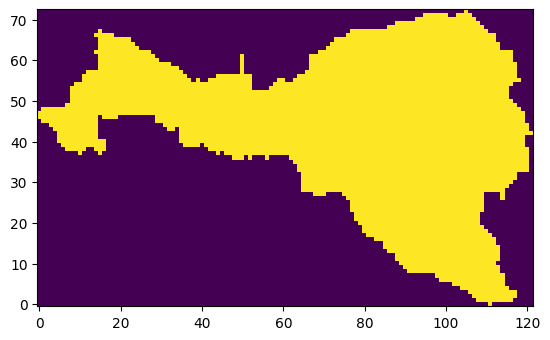

In [5]:
plt.imshow(mask, origin='lower')

## 5. Defining bounds for the upstream area of a collection of points
The subsettools [`define_upstream_domain`](https://hydroframesubsettools.readthedocs.io/en/latest/autoapi/subsettools/subsettools/index.html#subsettools.subsettools.define_upstream_domain) function returns a tuple `(imin, jmin, imax, jmax)` of grid indices that define a bounding box containing the upstream area of a collection of lat-lon points (outlets), and a mask for that domain.

In [6]:
outlets = [[39.8195, -75.3820]]
ij_upstream_area_bounds, mask = st.define_upstream_domain(outlets=outlets, grid="conus2")
print(f"bounding box: {ij_upstream_area_bounds}")

bounding box: (3874, 1883, 4054, 2180)


We can now visualize the upstream area mask and the grid point corresponding to the outlet. Note that to add the outlet to the figure, we need to convert the global grid coordinates of the outlet to local mask coordinates. To do this, we first compute the global grid coordinates using the `hf_hydrodata` function [to_ij](https://hf-hydrodata.readthedocs.io/en/latest/hf_hydrodata.grid.html#hf_hydrodata.grid.to_ij) and then subtract the lower-left corner of our mask `(imin, jmin)` from them:

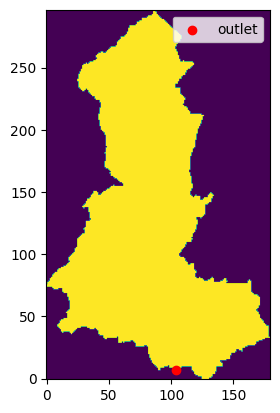

In [7]:
plt.imshow(mask, origin='lower')
imin, jmin, imax, jmax = ij_upstream_area_bounds
outlet_global_i, outlet_global_j = hf.to_ij("conus2", *outlets[0])
outlet_local_i, outlet_local_j = outlet_global_i - imin, outlet_global_j - jmin
plt.scatter(outlet_local_i, outlet_local_j, marker='o', c='r', label='outlet')
plt.legend()